# Libraries

In [2]:
# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers, models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

# System Libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import cv2
import seaborn as sns
from PIL import Image, ImageChops, ImageEnhance

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Helper Function

In [3]:
import urllib.request

url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
urllib.request.urlretrieve(url, "helper_functions.py")
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot

# Data

## Load and Tranform Data

In [4]:
BATCH_SIZE = 32
TARGET_SIZE = (224, 224)

In [5]:
# Walk through each directory
dataset = r"C:\Users\user\Documents\Datasets\Birds\train"
walk_through_dir(dataset)

There are 525 directories and 0 images in 'C:\Users\user\Documents\Datasets\Birds\train'.
There are 0 directories and 163 images in 'C:\Users\user\Documents\Datasets\Birds\train\ABBOTTS BABBLER'.
There are 0 directories and 180 images in 'C:\Users\user\Documents\Datasets\Birds\train\ABBOTTS BOOBY'.
There are 0 directories and 179 images in 'C:\Users\user\Documents\Datasets\Birds\train\ABYSSINIAN GROUND HORNBILL'.
There are 0 directories and 135 images in 'C:\Users\user\Documents\Datasets\Birds\train\AFRICAN CROWNED CRANE'.
There are 0 directories and 154 images in 'C:\Users\user\Documents\Datasets\Birds\train\AFRICAN EMERALD CUCKOO'.
There are 0 directories and 137 images in 'C:\Users\user\Documents\Datasets\Birds\train\AFRICAN FIREFINCH'.
There are 0 directories and 155 images in 'C:\Users\user\Documents\Datasets\Birds\train\AFRICAN OYSTER CATCHER'.
There are 0 directories and 187 images in 'C:\Users\user\Documents\Datasets\Birds\train\AFRICAN PIED HORNBILL'.
There are 0 directories a

## Placing data into Dataframe

In [6]:
image_dir = Path(dataset)

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.png')) + list(image_dir.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name = 'Filepath').astype(str)
labels = pd.Series(labels, name = 'Label')

# Concatenate filepath and labels
image_df = pd.concat([filepaths, labels], axis = 1)

C:\Users\user\AppData\Local\Temp\ipykernel_11956\1610367316.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = label_counts.index, y = label_counts.values, alpha = 0.8, palette='dark:salmon_r')


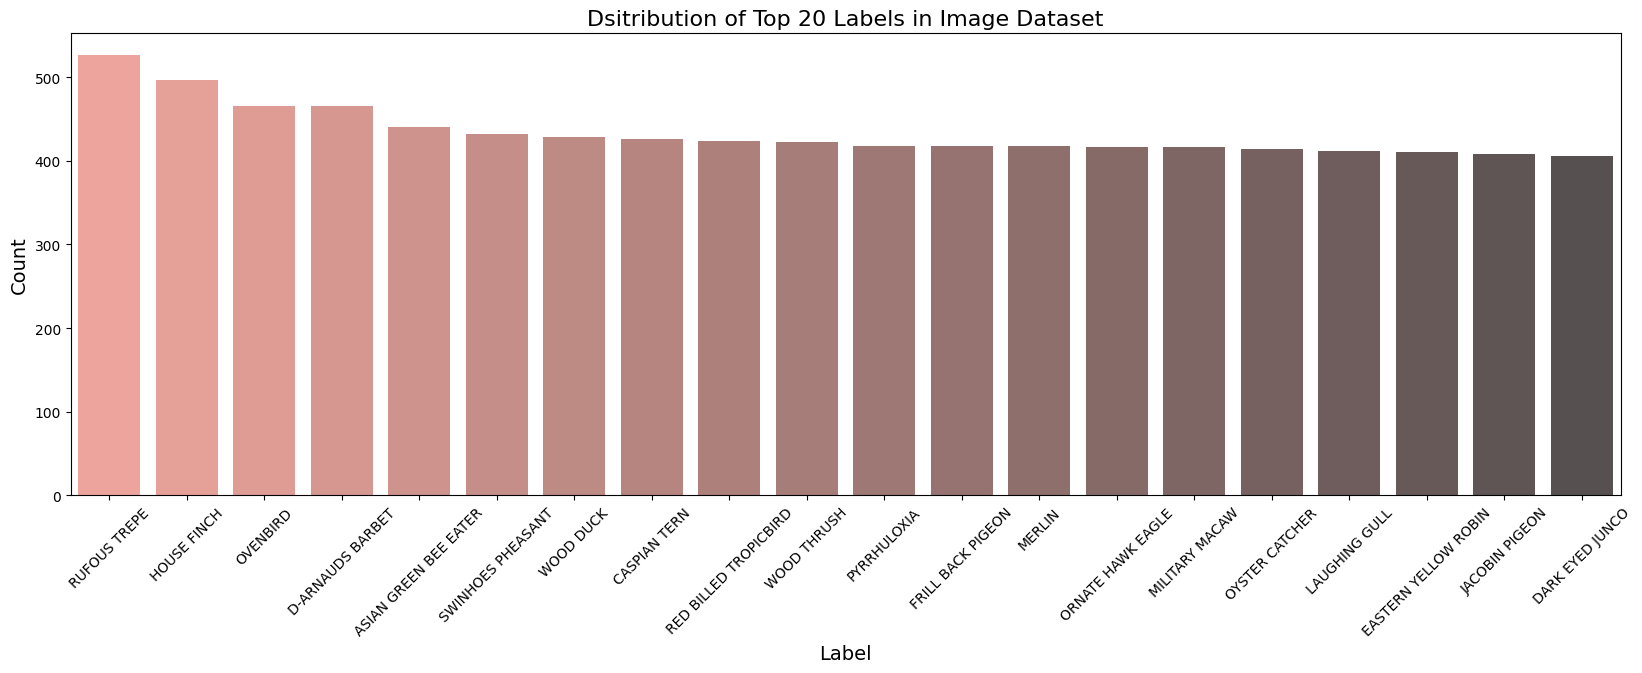

In [7]:
# Top 20 Labels
label_counts = image_df['Label'].value_counts()[:20]
plt.figure(figsize = (20, 6))
sns.barplot(x = label_counts.index, y = label_counts.values, alpha = 0.8, palette='dark:salmon_r')
plt.title('Dsitribution of Top 20 Labels in Image Dataset', fontsize = 16)
plt.xlabel('Label', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(rotation = 45)
plt.show()

## Visualizing Images from the dataset

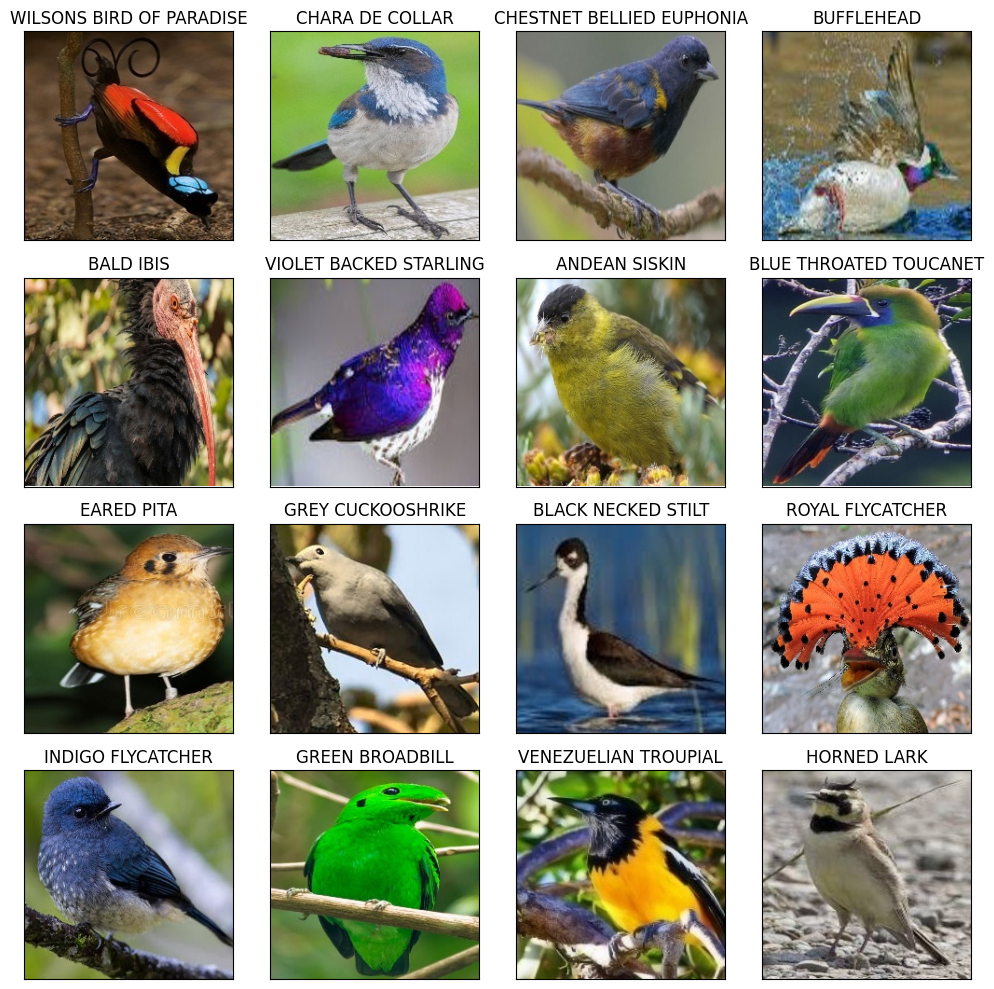

In [8]:
# Display 16 picture of the dataset with their labels
random_index = np.random.randint(0, len(image_df), 16)
fig, ax = plt.subplots(4, 4, figsize = (10, 10), 
                       subplot_kw = {'xticks': [], 'yticks': []})

for i, ax in enumerate(ax.flat):
    ax.imshow(plt.imread(image_df.Filepath[random_index[i]]))
    ax.set_title(image_df.Label[random_index[i]])
plt.tight_layout()
plt.show()

## Computing Error Analysis (ELA)
The compute_ela_cv() function takes an image path and a quality parameter, compresses the image using JPEG compression at the given quality, and computes the absolute difference between the compressed and original images. The difference is multiplied by a scale factor and returned as an ELA image.

In [9]:
def compute_ela_cv(path, quality):
    temp_filename = 'temp_filename.jpeg'
    SCALE = 15
    orig_img = cv2.imread(path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(temp_filename, orig_img, [cv2.IMWRITE_JPEG_QUALITY, quality])
    
    # Read compressed image
    compressed_img = cv2.imread(temp_filename)
    
    # Get absolute difference between img1 and img2 and multiply by scale
    diff = SCALE * cv2.absdiff(orig_img, compressed_img)
    
    return diff

def convert_to_ela_image(path, quality):
    temp_filename = 'temp_file_name.jpeg'
    ela_filename = 'temp_ela.png'
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    
    ela_image = ImageChops.difference(image, temp_image)
    
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    
    scale = 255.0/max_diff
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)
    
    return ela_image

def random_sample(path, extension = None):
    if extension:
        items = Path(path).glob(f'*.{extension}')
    else:
        items = Path(path).glob(f'*')
    
    items = list(items)
    
    p = random.choice(items)
    return p.as_posix()

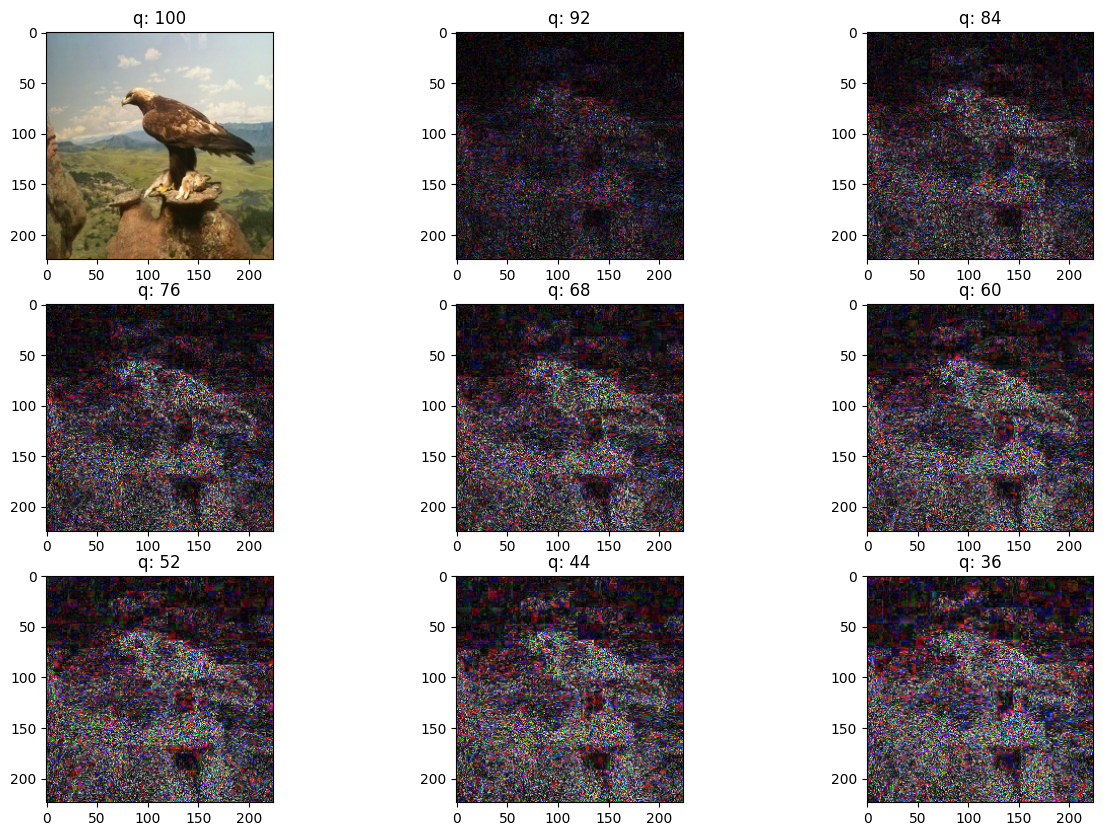

In [10]:
# View random sample from the dataset
p = random_sample(r'C:\Users\user\Documents\Datasets\Birds\train\GOLDEN EAGLE')
orig = cv2.imread(p)
orig = cv2.cvtColor(orig, cv2.COLOR_BGR2RGB) / 255.0
init_val = 100
columns = 3
rows = 3

fig = plt.figure(figsize = (15, 10))
for i in range(1, columns*rows + 1):
    quality = init_val - (i - 1) * 8
    img = compute_ela_cv(path = p, quality=quality)
    if i == 1:
        img = orig.copy()
    ax = fig.add_subplot(rows, columns, i)
    ax.title.set_text(f'q: {quality}')
    plt.imshow(img)
plt.show()

## Data Preprocessing

In [11]:
# Separate train and test data
train_df, test_df = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=42)

In [12]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [13]:
# Split the data into three categories
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed = 42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed = 42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 108333 validated image filenames belonging to 525 classes.
Found 27083 validated image filenames belonging to 525 classes.
Found 33854 validated image filenames belonging to 525 classes.


In [14]:
# Data Augmentation Step

augment = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(224, 224),
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomContrast(0.1)
])

# Training the Model

## Load Pre - Trained model

In [15]:
# Load the pre - trained model -> EfficientNetB0
pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

pretrained_model.trainable = False

## Create Checkpoint

In [16]:
# Checkpoint callback
checkpoint_path = 'birds_classification_model_checkpoint'
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only = True,
                                      monitor = 'val_accuracy',
                                      save_best_only = True)
# Setup EarlyStopping
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5,
                               restore_best_weights = True)

# Stop trainign
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr= 1e-6)

## Training Model

In [17]:
import os
from tensorflow.keras.models import load_model

model_path = "model.h5"

if os.path.exists(model_path):
    print("Model found. Loading the model...")
    model = load_model(model_path)
else:
    print("Model not found. Training the model...")
    
    inputs = pretrained_model.input
    x = augment(inputs)

    x = Dense(128, activation='relu')(pretrained_model.output)
    x = Dropout(0.45)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.45)(x)

    outputs = Dense(525, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer=Adam(0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_images,
        steps_per_epoch=len(train_images),
        validation_data=val_images,
        validation_steps=len(val_images),
        epochs=150,
        callbacks=[
            early_stopping,
            create_tensorboard_callback("training_logs", 
                                        "bird_classification"),
            checkpoint_callback,
            reduce_lr
        ]
    )
    
    model.save(model_path)


Model not found. Training the model...
Saving TensorBoard log files to: training_logs/bird_classification/20240831-104635
Epoch 1/150
3386/3386 [==============================] - 208s 58ms/step - loss: 5.7227 - accuracy: 0.0365 - val_loss: 3.7531 - val_accuracy: 0.3279 - lr: 1.0000e-04
Epoch 2/150
3386/3386 [==============================] - 274s 81ms/step - loss: 4.0057 - accuracy: 0.1659 - val_loss: 2.1405 - val_accuracy: 0.6158 - lr: 1.0000e-04
Epoch 3/150
3386/3386 [==============================] - 321s 95ms/step - loss: 3.1665 - accuracy: 0.2717 - val_loss: 1.4805 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 4/150
3386/3386 [==============================] - 303s 89ms/step - loss: 2.6878 - accuracy: 0.3505 - val_loss: 1.1513 - val_accuracy: 0.7725 - lr: 1.0000e-04
Epoch 5/150
3386/3386 [==============================] - 310s 92ms/step - loss: 2.3661 - accuracy: 0.4126 - val_loss: 0.9467 - val_accuracy: 0.8032 - lr: 1.0000e-04
Epoch 6/150
3386/3386 [==============================

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.